In [5]:
#Tratamiento de Datos
import pandas as pd
import numpy as np

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import shap
import lime
from lime import lime_tabular
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import warnings
warnings.filterwarnings("ignore")

In [6]:
sleep=pd.read_csv('../src/data/processed/sleep.csv')
df=sleep.copy()

In [7]:
# Separación en X e y
X = df.drop(['Sleep quality'], axis=1)
y = df['Sleep quality']

In [8]:
correlation = X.corrwith(y).abs().sort_values(ascending=False)
print('Sleep quality correlation:')
print(correlation.head(15))

Sleep quality correlation:
Heart rate                   0.014326
Wake up during night_Y       0.011436
Physical activity            0.010329
Height                       0.009380
Feel sleepy during day_Y     0.008145
Blue-light filter_Y          0.007969
Smoking_Y                    0.006971
Ongoing medication_Y         0.005858
Gender_F                     0.005695
Weight                       0.005604
Sleep duration               0.005317
Smart device before bed_Y    0.005133
Average screen time          0.004697
Caffeine consumption_Y       0.003947
Alcohol consumption_Y        0.003578
dtype: float64


In [9]:
#Separación en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.to_csv("X_train_raw.csv", index=False)
X_test.to_csv("X_test_raw.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

In [10]:
print(f"Tamaño del conjunto del entrenamiento X:{X_train.shape}")
print(f"Tamaño del conjunto del test X:{X_test.shape}")

Tamaño del conjunto del entrenamiento X:(16000, 23)
Tamaño del conjunto del test X:(4000, 23)


Sleep quality
3    20.120
4    20.050
1    20.015
2    19.975
5    19.840
Name: proportion, dtype: float64


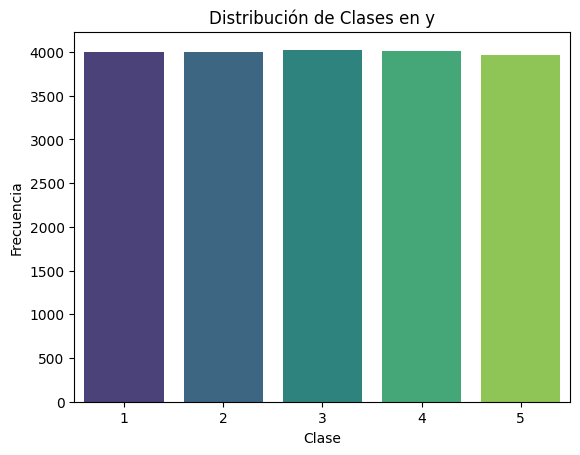

In [11]:
balance = df['Sleep quality'].value_counts(normalize=True) * 100
print(balance)

sns.countplot(x=y, palette="viridis")
plt.title("Distribución de Clases en y")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.show()

Best characteristics: ['Age', 'Sleep duration', 'Stress level', 'Heart rate', 'Daily steps', 'Physical activity', 'Height', 'Weight', 'Average screen time', 'Sleep disorder_Y', 'Wake up during night_Y', 'Feel sleepy during day_Y', 'Caffeine consumption_Y', 'Alcohol consumption_Y', 'Smoking_Y', 'Medical issue_Y', 'Ongoing medication_Y', 'Blue-light filter_Y', 'Blood Pressure', 'BMI']


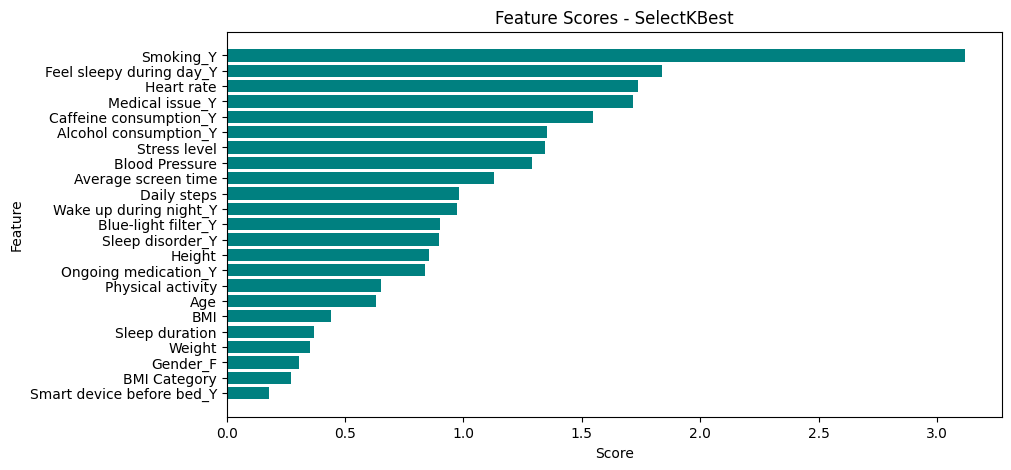

                      Feature     Score
15                  Smoking_Y  3.117390
12   Feel sleepy during day_Y  1.837103
3                  Heart rate  1.735343
16            Medical issue_Y  1.715167
13     Caffeine consumption_Y  1.547798
14      Alcohol consumption_Y  1.353471
2                Stress level  1.345632
20             Blood Pressure  1.291466
8         Average screen time  1.128418
4                 Daily steps  0.980590
11     Wake up during night_Y  0.972652
19        Blue-light filter_Y  0.900987
10           Sleep disorder_Y  0.897420
6                      Height  0.854990
17       Ongoing medication_Y  0.835828
5           Physical activity  0.652578
0                         Age  0.631895
21                        BMI  0.441286
1              Sleep duration  0.367447
7                      Weight  0.351069
9                    Gender_F  0.306803
22               BMI Category  0.269858
18  Smart device before bed_Y  0.177989


In [ ]:
# Entrenar modelo SelectKBest

selector = SelectKBest(score_func=f_classif, k=20)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Ver qué características fueron seleccionadas
selectedK_features = X_train.columns[selector.get_support()]
print("Best characteristics:", selectedK_features.tolist())

# Conseguir Feature scores
KBest_scores = pd.DataFrame({"Feature": X_train.columns, "Score": selector.scores_})
sorted_scores = KBest_scores.sort_values(by="Score", ascending=False)

# Graficar los puntajes de las características
plt.figure(figsize=(10,5))
plt.barh(sorted_scores["Feature"], sorted_scores["Score"], color="teal")
plt.xlabel("Score")
plt.ylabel("Feature")
plt.title("Feature Scores - SelectKBest")
plt.gca().invert_yaxis()  # Invertir eje para que las más importantes estén arriba
plt.show()

sorted_scores.to_csv("KBest_X_train.csv", index=False)

# Mostrar las características ordenadas por puntaje
print(sorted_scores)


Top Random Forest Characteristics:
Physical activity            0.092145
Average screen time          0.088417
BMI                          0.085606
Heart rate                   0.080141
Height                       0.079586
Weight                       0.077741
Age                          0.076908
Daily steps                  0.072673
Stress level                 0.042663
Sleep duration               0.036237
Blood Pressure               0.034470
BMI Category                 0.024184
Gender_F                     0.020106
Wake up during night_Y       0.019940
Smart device before bed_Y    0.019630
Caffeine consumption_Y       0.019530
Ongoing medication_Y         0.019471
Sleep disorder_Y             0.019291
Medical issue_Y              0.019170
Alcohol consumption_Y        0.018885
Blue-light filter_Y          0.018632
Feel sleepy during day_Y     0.018417
Smoking_Y                    0.016157
dtype: float64


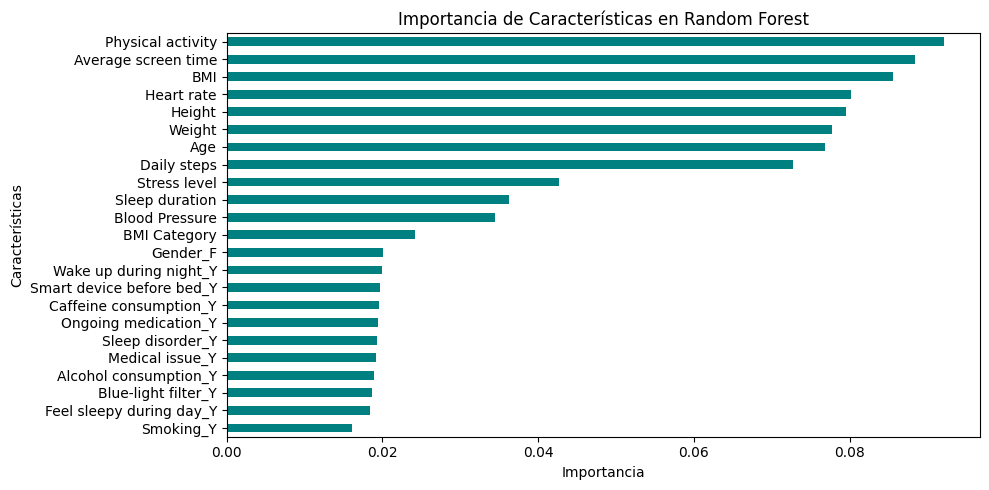

In [46]:
# Entrenar modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Obtener y visualizar la importancia de las características
rf_importance = pd.Series(rf.feature_importances_, index = X.columns).sort_values(ascending=False)
print('\nTop Random Forest Characteristics:')
print(rf_importance.head(24))

plt.figure(figsize=(10, 5))
rf_importance.head(24).plot(kind='barh', color='teal') 
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.title("Importancia de Características en Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [47]:
X_train_selected = X_train[rf_importance.head(24).index]
X_test_selected = X_test[rf_importance.head(24).index]

print('\nDimensiones del conjunto de datos seleccionado:', X_train_selected.shape, X_test_selected.shape)


Dimensiones del conjunto de datos seleccionado: (16000, 23) (4000, 23)


In [48]:
# Estandarización de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

In [49]:
# PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

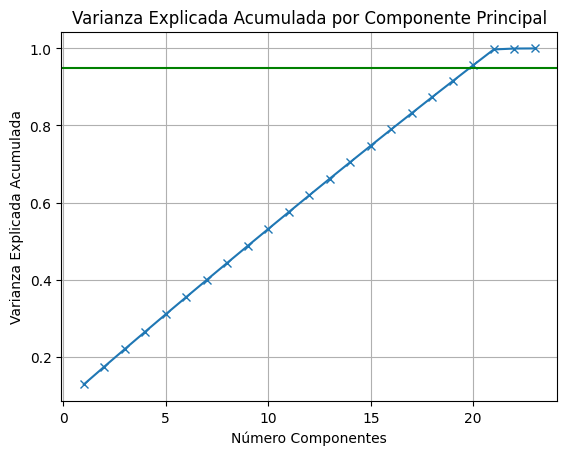

In [50]:
fig, ax = plt.subplots()

varianza_explicada = pca.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

ax.plot(range(1, len(varianza_acumulada) + 1), varianza_acumulada, marker='x', linestyle = '-')
ax.axhline(y=0.95, color='g', linestyle='solid')
ax.set_xlabel('Número Componentes')
ax.set_ylabel('Varianza Explicada Acumulada')
ax.set_title('Varianza Explicada Acumulada por Componente Principal')
plt.grid(True)

plt.show()

In [51]:
n_componentes = np.argmax(varianza_acumulada >= 0.95) + 1
print(f'\nNúmero óptimo de componentes para explicar el 95% de la varianza: {n_componentes}')


Número óptimo de componentes para explicar el 95% de la varianza: 20


In [52]:
pca = PCA(20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f'Dimensiones después de PCA (X_train): {X_train_pca.shape}')
print(f'Dimensiones después de PCA (X_test): {X_test_pca.shape}')

pd.DataFrame(X_train_pca).to_csv("X_train_pca.csv", index=False)
pd.DataFrame(X_test_pca).to_csv("X_test_pca.csv", index=False)

Dimensiones después de PCA (X_train): (16000, 20)
Dimensiones después de PCA (X_test): (4000, 20)


## BASE LINE

In [54]:
# Modelo Dummy

dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)
y_pred= dummy.predict(X_test)
y_prob = dummy.predict_proba(X_test) if hasattr(dummy, "predict_proba") else None
print("Stratified Dummy Model (Baseline)")

# Métricas

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

precision_macro = precision_score(y_test, y_pred, average="macro")
print(f"Precision (macro): {precision_macro*100:.2f}%")

precision_weighted = precision_score(y_test, y_pred, average="weighted")
print(f"Precision (weighted): {precision_weighted*100:.2f}%")

recall_macro = recall_score(y_test, y_pred, average="macro")
print(f"Recall (macro): {recall_macro*100:.2f}%")

recall_weighted = recall_score(y_test, y_pred, average="weighted")
print(f"Recall (weighted): {recall_weighted*100:.2f}%")

f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"F1 Score (macro): {f1_macro*100:.2f}%")

f1_weighted = f1_score(y_test, y_pred, average="weighted")
print(f"F1 Score (weighted): {f1_weighted*100:.2f}%")

logloss = log_loss(y_test, y_prob) if y_prob is not None else np.nan
print(f"Log Loss: {logloss:.4f}")

Stratified Dummy Model (Baseline)
Accuracy: 20.15%
Precision (macro): 20.15%
Precision (weighted): 20.15%
Recall (macro): 20.16%
Recall (weighted): 20.15%
F1 Score (macro): 20.14%
F1 Score (weighted): 20.14%
Log Loss: 28.7809


In [55]:
# Modelo Dummy

dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(X_train, y_train)
y_pred= dummy.predict(X_test)
y_prob = dummy.predict_proba(X_test) if hasattr(dummy, "predict_proba") else None
print("Dummy Model (Baseline)")

# Métricas

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

precision_macro = precision_score(y_test, y_pred, average="macro")
print(f"Precision (macro): {precision_macro*100:.2f}%")

precision_weighted = precision_score(y_test, y_pred, average="weighted")
print(f"Precision (weighted): {precision_weighted*100:.2f}%")

recall_macro = recall_score(y_test, y_pred, average="macro")
print(f"Recall (macro): {recall_macro*100:.2f}%")

recall_weighted = recall_score(y_test, y_pred, average="weighted")
print(f"Recall (weighted): {recall_weighted*100:.2f}%")

f1_macro = f1_score(y_test, y_pred, average="macro")
print(f"F1 Score (macro): {f1_macro*100:.2f}%")

f1_weighted = f1_score(y_test, y_pred, average="weighted")
print(f"F1 Score (weighted): {f1_weighted*100:.2f}%")

logloss = log_loss(y_test, y_prob) if y_prob is not None else np.nan
print(f"Log Loss: {logloss:.4f}")

Dummy Model (Baseline)
Accuracy: 19.53%
Precision (macro): 19.54%
Precision (weighted): 19.57%
Recall (macro): 19.50%
Recall (weighted): 19.53%
F1 Score (macro): 19.52%
F1 Score (weighted): 19.54%
Log Loss: 1.6094


#### Conclusiones
Hay 5 clases en el target que están muy balanceadas (sus valores van de 20.12 a 19.84), por lo que 19.53% de accuracy es lo esperado. Sin embargo el Log Loss = 1.6094 es bastante bajo, por lo que las probabilidades son muy buenas.
El modelo Dummy demuestra que el dataset está balanceado y que los modelos reales deberían poder superar el 20% de precisión. En caso contrario, podría haber un problema con los datos.

                  Model  Accuracy  Precision (macro)  Precision (weighted)  \
7   K-Nearest Neighbors    20.160          20.151738             20.151430   
1   Logistic Regression    20.075          20.120656             20.119817   
2  Gaussian Naive Bayes    19.965          19.770521             19.770762   
4     Gradient Boosting    19.900          19.870394             19.872774   
5    Bagging Classifier    19.705          20.185907             20.082170   
3         Decision Tree    19.690          19.704626             19.700866   
0         Random Forest    19.475          19.455417             19.457174   
6           Extra Trees    19.285          19.526697             19.788464   

   Recall (macro)  Recall (weighted)  F1 Score (macro)  F1 Score (weighted)  \
7       20.150254             20.160         19.794001            19.799686   
1       20.075910             20.075         19.581594            19.580227   
2       19.960906             19.965         19.488382      

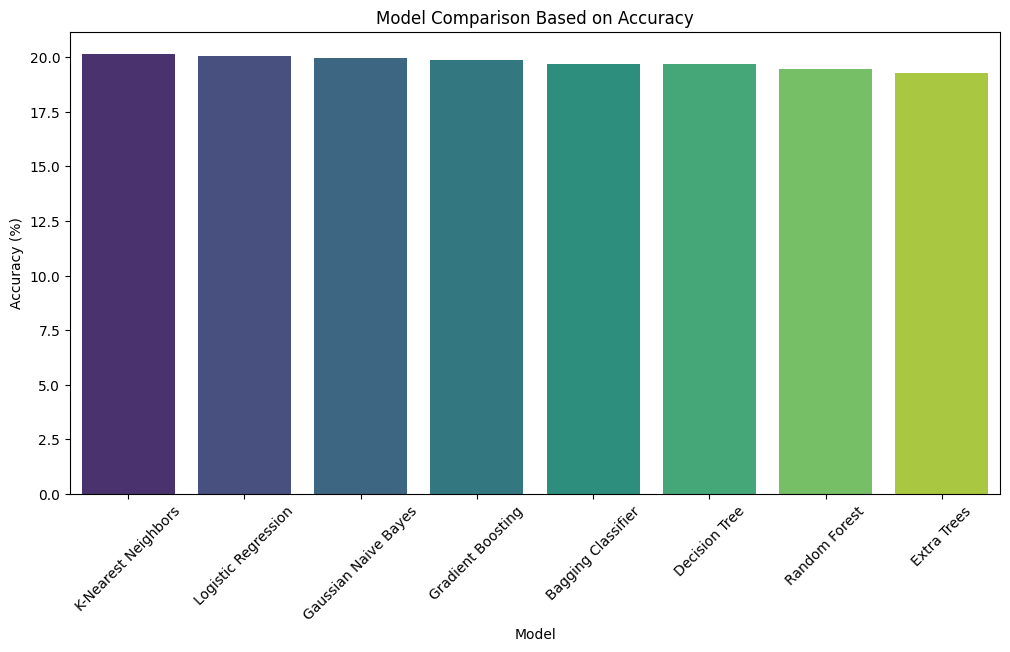


Best base model: K-Nearest Neighbors


In [57]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Gaussian Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Bagging Classifier": BaggingClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
}

metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision (macro)': [],
    'Precision (weighted)': [],
    'Recall (macro)': [],
    'Recall (weighted)': [],
    'F1 Score (macro)': [],
    'F1 Score (weighted)': [],
    'Log Loss': [],
}

# Stratified cross-validation with 5 folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate models
for name, model in models.items():
    acc = cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
    precision_macro = cross_val_score(model, X, y, cv=cv, scoring='precision_macro').mean()
    precision_weighted = cross_val_score(model, X, y, cv=cv, scoring='precision_weighted').mean()
    recall_macro = cross_val_score(model, X, y, cv=cv, scoring='recall_macro').mean()
    recall_weighted = cross_val_score(model, X, y, cv=cv, scoring='recall_weighted').mean()
    f1_macro = cross_val_score(model, X, y, cv=cv, scoring='f1_macro').mean()
    f1_weighted = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted').mean()
    
    # Log Loss requires probability predictions
    log_loss_score = -cross_val_score(model, X, y, cv=cv, scoring='neg_log_loss').mean() if hasattr(model, "predict_proba") else np.nan

    # Store metrics
    metrics['Model'].append(name)
    metrics['Accuracy'].append(acc * 100)
    metrics['Precision (macro)'].append(precision_macro * 100)
    metrics['Precision (weighted)'].append(precision_weighted * 100)
    metrics['Recall (macro)'].append(recall_macro * 100)
    metrics['Recall (weighted)'].append(recall_weighted * 100)
    metrics['F1 Score (macro)'].append(f1_macro * 100)
    metrics['F1 Score (weighted)'].append(f1_weighted * 100)
    metrics['Log Loss'].append(log_loss_score)

# Convert results to DataFrame
df_metrics = pd.DataFrame(metrics)

# Sort by accuracy
df_metrics = df_metrics.sort_values(by="Accuracy", ascending=False)

# Print results
print(df_metrics)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(x=df_metrics["Model"], y=df_metrics["Accuracy"], palette="viridis")
plt.title("Model Comparison Based on Accuracy")
plt.xlabel("Model")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.show()

# Select the best model based on Accuracy
best_model_name = df_metrics.iloc[0]["Model"]
print(f"\nBest base model: {best_model_name}")

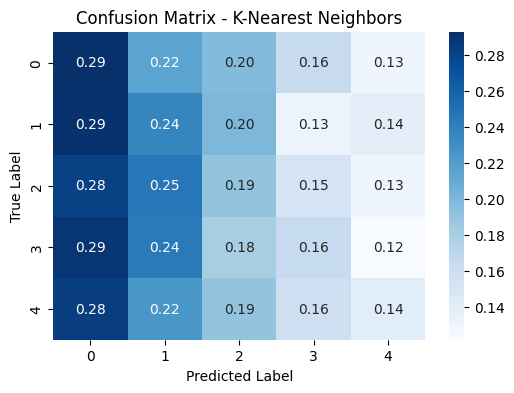

Mejor modelo seleccionado: K-Nearest Neighbors


In [58]:
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = best_model.predict(X_test)

# Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred, normalize="true")

# Visualizar matriz de confusión
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print(f"Mejor modelo seleccionado: {best_model_name}")

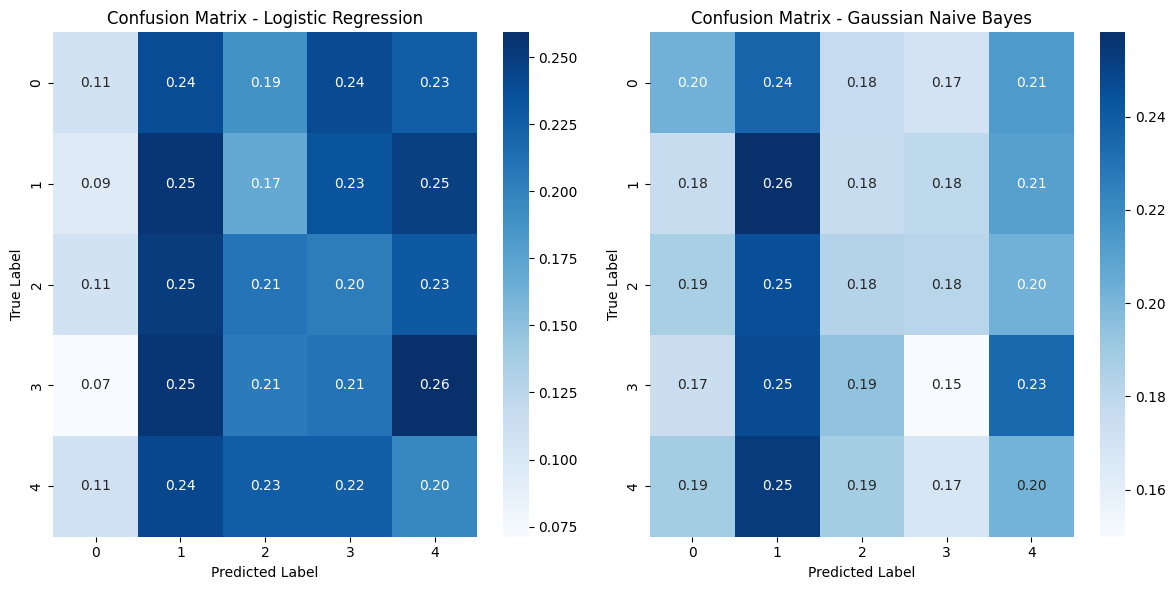

Modelo utilizado: Logistic Regression
Modelo utilizado: Gaussian Naive Bayes


In [59]:
# Ajustar los modelos con los datos de entrenamiento
logreg_model = LogisticRegression(max_iter=1000)
gnb_model = GaussianNB()

# Ajustar los modelos con los datos de entrenamiento
logreg_model.fit(X_train, y_train)
gnb_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_logreg = logreg_model.predict(X_test)
y_pred_gnb = gnb_model.predict(X_test)

# Generar matrices de confusión normalizadas
cm_logreg = confusion_matrix(y_test, y_pred_logreg, normalize='true')
cm_gnb = confusion_matrix(y_test, y_pred_gnb, normalize='true')

# Visualizar la matriz de confusión de Logistic Regression
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_logreg, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Visualizar la matriz de confusión de Gaussian Naive Bayes
plt.subplot(1, 2, 2)
sns.heatmap(cm_gnb, annot=True, fmt=".2f", cmap="Blues")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Imprimir el nombre de los modelos para referencia
print("Modelo utilizado: Logistic Regression")
print("Modelo utilizado: Gaussian Naive Bayes")

In [60]:
# Para medir el accuracy de la matriz de confusión se realizará Accuracy = (Sum of diagonal elements) / (Total sum of all elements)
KNN_Accuracy = (0.29 + 0.24 + 0.19 + 0.16 + 0.14) / 5 * 100
print(f"K-Nearest Neighbors Accuracy: {KNN_Accuracy}%")

LR_Accuracy = (0.11 + 0.25 + 0.21 + 0.21 + 0.20) / 5 * 100
print(f"Logistic Regression Accuracy: {LR_Accuracy}%")

GNB_Accuracy = (0.20 + 0.26 + 0.18 + 0.15 + 0.20) / 5 * 100
print(f"Gaussian Naive Bayes Accuracy: {GNB_Accuracy}%")

K-Nearest Neighbors Accuracy: 20.400000000000002%
Logistic Regression Accuracy: 19.6%
Gaussian Naive Bayes Accuracy: 19.8%
